# MNIST Classification using Neural Networks with Pytorch

In [1]:
import torch 
from torchvision import datasets,transforms as T 
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch import optim,nn
import torch.nn.functional as F 
from torchsummary import summary
import matplotlib.pyplot as plt 
import numpy as np 
from utils import multiclass_accuracy,view_classify

ModuleNotFoundError: No module named 'torchsummary'

## Loading and Visualizing MNIST Dataset 

In [2]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

In [3]:
trainset = datasets.MNIST('MNIST_data/',download = True,train = True,transform=transform)
testset = datasets.MNIST('MNIST_data/',download=True,train=False,transform=transform)

In [4]:
print("Length of trainset {}".format(len(trainset)))
print("Length of testset {}".format(len(testset)))

Length of trainset 60000
Length of testset 10000


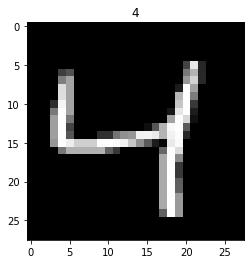

In [5]:
n = 2
image,label = trainset[2]
plt.imshow(image.numpy().squeeze(),cmap = "gray")
plt.title(label);

## Splitting Dataset and Setting the Train, Validation and Test DataLoaders

In [6]:
valid_size = 0.2 

num_train = len(trainset)    #60000
indices = list(range(num_train))  #[0,1,2,3,.....59999]
np.random.shuffle(indices)  #[2,3,40000,3,.....6,10]
split = int(np.floor(valid_size*num_train)) #12000
train_idx, valid_idx = indices[split:],indices[:split]

In [7]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [8]:
trainloader = DataLoader(trainset, batch_size = 64, sampler = train_sampler)
testloader = DataLoader(testset, batch_size = 64)
validloader = DataLoader(trainset,batch_size=64,sampler=valid_sampler)

In [9]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


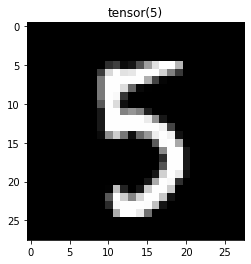

In [10]:
n = 60
plt.imshow(images[n].numpy().squeeze(),cmap='gray')
plt.title(labels[n]);

## Creating a simple Neural Network 

In [11]:
class Classifier(nn.Module):

    def __init__(self):
        super(Classifier,self).__init__()

        self.linear1 = nn.Linear(28*28,256)
        self.linear2 = nn.Linear(256,128)
        self.linear3 = nn.Linear(128,10)
        self.dropout = nn.Dropout(0.4)

    def forward(self,x):

        x = x.view(x.shape[0],-1) #(1,784)

        z1 = self.linear1(x)
        a1 = self.dropout(F.relu(z1))

        z2 = self.linear2(a1)
        a2 = self.dropout(F.relu(z2))

        z3 = self.linear3(a2)
        a3 = self.dropout(F.log_softmax(z3,dim=1))

        return a3

In [12]:
model = Classifier()
model

Classifier(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [13]:
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
           Dropout-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
           Dropout-6                   [-1, 10]               0
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


## Training the Neural Network

In [14]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epochs = 10

In [15]:
for e in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0

    model.train()

    for images,labels in trainloader:

        optimizer.zero_grad()
        logps = model(images)
        loss = criterion(logps,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()

    for images,labels in validloader:

        logps = model(images)
        loss = criterion(logps,labels)
        valid_loss += loss.item()
        valid_acc += multiclass_accuracy(torch.exp(logps),labels)

    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    valid_acc = valid_acc/len(validloader)

    print("Epoch : {} Training Loss : {:.4f} Validation Loss: {:.4f} Validation acc : {:.4f}".format(e+1,train_loss,valid_loss,valid_acc))

Epoch : 1 Training Loss : 0.7323 Validation Loss: 0.3478 Validation acc : 0.8950
Epoch : 2 Training Loss : 0.5455 Validation Loss: 0.3094 Validation acc : 0.9122
Epoch : 3 Training Loss : 0.4912 Validation Loss: 0.3020 Validation acc : 0.9051
Epoch : 4 Training Loss : 0.4779 Validation Loss: 0.3072 Validation acc : 0.9092
Epoch : 5 Training Loss : 0.4558 Validation Loss: 0.2805 Validation acc : 0.9160
Epoch : 6 Training Loss : 0.4502 Validation Loss: 0.2943 Validation acc : 0.9102
Epoch : 7 Training Loss : 0.4261 Validation Loss: 0.2527 Validation acc : 0.9259
Epoch : 8 Training Loss : 0.4391 Validation Loss: 0.2425 Validation acc : 0.9297
Epoch : 9 Training Loss : 0.4400 Validation Loss: 0.2608 Validation acc : 0.9215
Epoch : 10 Training Loss : 0.4190 Validation Loss: 0.2423 Validation acc : 0.9313


## Evaluating the Model

In [16]:
model.eval()

loss = 0
acc = 0
for images,labels in testloader:

    logps = model(images)
    loss += criterion(logps,labels)
    ps = torch.exp(logps)
    acc += multiclass_accuracy(ps,labels)

print("Test loss : {:.4f} Test accuracy : {:.4f}".format(loss/len(testloader),acc/len(testloader)))

Test loss : 0.2302 Test accuracy : 0.9341


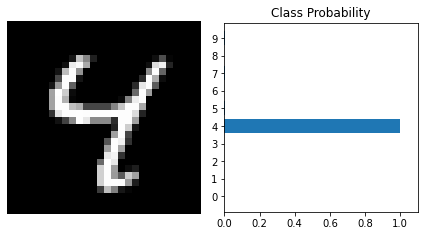

In [17]:
dataiter = iter(testloader)
images,labels = dataiter.next()

n = 6
logps = model(images[n])
ps = torch.exp(logps)

view_classify(images[n],ps)